In [1]:
# Importing datasets
import pandas as pd
import numpy as np


In [2]:
# Read train and test
train = pd.read_csv('Train.csv',parse_dates=[1])
test = pd.read_csv('Test.csv')
df = train.copy()
df_test =test.copy()

# Convert to datetime format


In [3]:
df.head()

,ID,Datetime,Count
0,0,2012-08-25 00:00:00,8
1,1,2012-08-25 01:00:00,2
2,2,2012-08-25 02:00:00,6
3,3,2012-08-25 03:00:00,2
4,4,2012-08-25 04:00:00,2


In [4]:
df['year'] = df['Datetime'].dt.year
df['month'] = df['Datetime'].dt.month
df['day'] = df['Datetime'].dt.day
df['hour'] = df['Datetime'].dt.hour

In [5]:
df.head()

,ID,Datetime,Count,year,month,day,hour
0,0,2012-08-25 00:00:00,8,2012,8,25,0
1,1,2012-08-25 01:00:00,2,2012,8,25,1
2,2,2012-08-25 02:00:00,6,2012,8,25,2
3,3,2012-08-25 03:00:00,2,2012,8,25,3
4,4,2012-08-25 04:00:00,2,2012,8,25,4


# lag features

In [6]:
df['lag1'] = df['Count'].shift(1)
df['lag2'] = df['Count'].shift(2)

In [7]:
df.head()

,ID,Datetime,Count,year,month,day,hour,lag1,lag2
0,0,2012-08-25 00:00:00,8,2012,8,25,0,NaN,NaN
1,1,2012-08-25 01:00:00,2,2012,8,25,1,8.0,NaN
2,2,2012-08-25 02:00:00,6,2012,8,25,2,2.0,8.0
3,3,2012-08-25 03:00:00,2,2012,8,25,3,6.0,2.0
4,4,2012-08-25 04:00:00,2,2012,8,25,4,2.0,6.0


# window features

In [14]:
df['roll_mean'] = df['Count'].rolling(window = 12).mean()

In [16]:
df['roll_max'] = df['Count'].rolling(window = 12).max()

In [17]:
df.head(20)

,ID,Datetime,Count,year,month,day,hour,lag1,lag2,roll_mean,roll_max
0,0,2012-08-25 00:00:00,8,2012,8,25,0,NaN,NaN,NaN,NaN
1,1,2012-08-25 01:00:00,2,2012,8,25,1,8.0,NaN,NaN,NaN
2,2,2012-08-25 02:00:00,6,2012,8,25,2,2.0,8.0,NaN,NaN
3,3,2012-08-25 03:00:00,2,2012,8,25,3,6.0,2.0,NaN,NaN
4,4,2012-08-25 04:00:00,2,2012,8,25,4,2.0,6.0,NaN,NaN
5,5,2012-08-25 05:00:00,2,2012,8,25,5,2.0,2.0,NaN,NaN
6,6,2012-08-25 06:00:00,2,2012,8,25,6,2.0,2.0,NaN,NaN
7,7,2012-08-25 07:00:00,2,2012,8,25,7,2.0,2.0,NaN,NaN
8,8,2012-08-25 08:00:00,6,2012,8,25,8,2.0,2.0,NaN,NaN
9,9,2012-08-25 09:00:00,2,2012,8,25,9,6.0,2.0,NaN,NaN


# expanding features

In [18]:
df['expand_max'] = df['Count'].expanding().max()

In [20]:
df.head()

,ID,Datetime,Count,year,month,day,hour,lag1,lag2,roll_mean,roll_max,expand_max
0,0,2012-08-25 00:00:00,8,2012,8,25,0,NaN,NaN,NaN,NaN,8.0
1,1,2012-08-25 01:00:00,2,2012,8,25,1,8.0,NaN,NaN,NaN,8.0
2,2,2012-08-25 02:00:00,6,2012,8,25,2,2.0,8.0,NaN,NaN,8.0
3,3,2012-08-25 03:00:00,2,2012,8,25,3,6.0,2.0,NaN,NaN,8.0
4,4,2012-08-25 04:00:00,2,2012,8,25,4,2.0,6.0,NaN,NaN,8.0


### timeseries data visualization

In [21]:
from matplotlib import pyplot as plt
%matplotlib inline

In [22]:
data_viz = train

In [24]:
data_viz.head()

,ID,Datetime,Count
0,0,2012-08-25 00:00:00,8
1,1,2012-08-25 01:00:00,2
2,2,2012-08-25 02:00:00,6
3,3,2012-08-25 03:00:00,2
4,4,2012-08-25 04:00:00,2


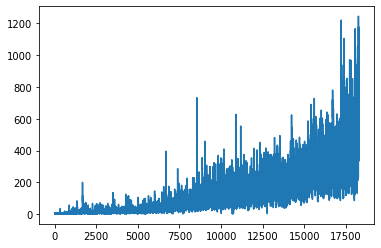

In [25]:
data_viz['Count'].plot()

In [26]:
data_viz.index = data_viz['Datetime']

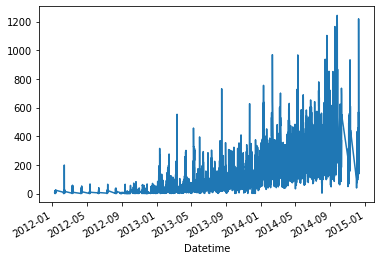

In [27]:
data_viz['Count'].plot()

### Zooming in

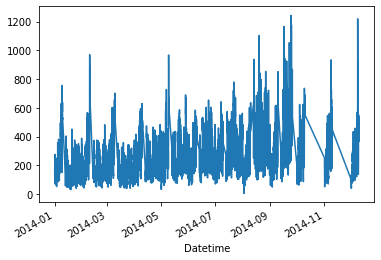

In [40]:
data_viz[(data_viz['Datetime'] > '2014')]['Count'].plot()

### Trendline 

In [35]:
import seaborn as sns

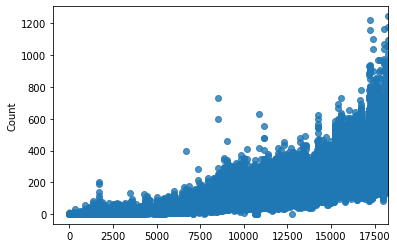

In [39]:
sns.regplot(x=df.index.values, y= df.Count, order=4)